<a href="https://colab.research.google.com/github/henry-bokyum-kim/NNStudy/blob/bokyum/FastRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # download the Penn-Fudan dataset
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
# # extract it in the current folder
# !unzip PennFudanPed.zip

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import torchvision.transforms as transforms

import random

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
    transforms.Resize((800,800)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder('./PennFudanPed', transform=trans)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False)

In [3]:
import os

#get shapes
image_list = os.listdir('./PennFudanPed/PNGImages/')
image_list.sort()
image_list

from PIL import Image
file_path = './PennFudanPed/PNGImages/'

shapes = []
for i in image_list:
    shapes.append(np.array(Image.open(file_path + i)).shape[:-1])

In [4]:
#get boxes
import json
import re

p = re.compile('.*(object [0-9]).* : (.*)')

file_path = './PennFudanPed/Annotation/'

anno_list = os.listdir('./PennFudanPed/Annotation/')
anno_list.sort()
anno_list

annotation = []
for i in anno_list:
    txt = open(file_path + i, 'r')
    anno = {}
    for l in txt.readlines():
        match = p.match(l)
        if match:
            key, value = match.groups()
            if key not in anno:
                anno[key] = []
            anno[key].append(value)
    annotation.append(anno)

an = [[list(map(lambda x:json.loads(x), row[key][1].replace('(', '[').replace(')',']').split(' - '))) for key in row] for row in annotation]

In [5]:
#caculate reshaped box boundaries
resized_boxes = []
for shape, boxes in zip(shapes, an):
    h_ratio = 800/shape[0]
    w_ratio = 800/shape[1]
    
    resized = []
    for box in boxes:
        x0 = round(box[0][0] * w_ratio)
        y0 = round(box[0][1] * h_ratio)
        x1 = round(box[1][0] * w_ratio)
        y1 = round(box[1][1] * h_ratio)
        
        resized.append([(x0,y0), (x1,y1)])
        
    resized_boxes.append(resized)

In [6]:
def draw_boxes(ax, boxes, color='r'):
    for box in boxes:
        rect = patches.Rectangle((box[0][0], box[0][1]), box[1][0]-box[0][0], box[1][1]-box[0][1], linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

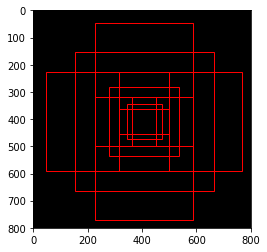

In [7]:
import torch
width = 800
heigth = 800
subsample = 16
image = torch.zeros((1, 3, width, heigth)).float()

w_cntrs = list(range(int(subsample/2), width, subsample))
h_cntrs = list(range(int(subsample/2), heigth, subsample))

import math

def get_anchor(w_, h_, subsample, ratio=(0.5,1,2), size=None):
    if size == None:
        size = (int(subsample/2), subsample, subsample*2)
        
    anchors = []
    for r_ in ratio:
        anchor_ratio = np.array((math.sqrt(r_), math.sqrt(1/r_)))
        for s_ in size:
            anchor_shape = anchor_ratio * s_ * subsample
            x0 = round(w_ - anchor_shape[0]/2)
            x1 = round(w_ + anchor_shape[0]/2)
            y0 = round(h_ - anchor_shape[1]/2)
            y1 = round(h_ + anchor_shape[1]/2)
            
            anchors.append([(x0,y0),(x1,y1)])
    return np.array(anchors)

anchor = get_anchor(w_cntrs[25], h_cntrs[25], subsample)

fig, ax = plt.subplots(1)

ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, anchor)

In [8]:
# generate anchors
anchors = []
for y in range(int(subsample/2),800,subsample):
    for x in range(int(subsample/2),800,subsample):
        anchor = get_anchor(x,y,subsample)
        anchors.extend(anchor)
anchors = np.array(anchors)

index_inside = np.where(
        (anchors[:,0,0] >= 0) &
        (anchors[:,0,1] >= 0) &
        (anchors[:,1,0] <= 800) &
        (anchors[:,1,1] <= 800)
    )[0]

anchors_inside = anchors[index_inside]

In [9]:
#calculate iou and make labelset

def get_iou(b1, b2):
    a1 = (b1[1][0] - b1[0][0]) * (b1[1][1] - b1[0][1])
    a2 = (b2[1][0] - b2[0][0]) * (b2[1][1] - b2[0][1])
    ai = max(0,(min(b1[1][0], b2[1][0]) - max(b1[0][0], b2[0][0]))) \
    * max(0,(min(b1[1][1], b2[1][1]) - max(b1[0][1], b2[0][1])))
    
    au = a1 + a2 - ai
    return ai/au

labels = []
norm_locs = []
for i, target in enumerate(resized_boxes):
    pos_indices = False
    neg_indices = True
    ious = []
    for target_box in target:
        iou_list = []
        for inside in anchors_inside:
            iou = get_iou(inside,target_box)
            iou_list.append(iou)
        iou_list = np.array(iou_list)

        pos = iou_list > 0.7
        if pos.sum() < 1:
            pos[iou_list.argmax()] = 1

        neg = iou_list < 0.3
        pos_indices = pos_indices + pos
        neg_indices = neg_indices * neg
        ious.append(iou_list)

    label = -np.ones(len(anchors_inside))
    label[neg_indices] = 0
    label[pos_indices] = 1
    
    final_label = -np.ones(len(anchors))
    final_label[index_inside] = np.array(label)
    
    labels.append(final_label)
    
    ious = np.array(ious)
    max_iou_box = np.array([target[i] for i in ious.argmax(0)])
    
    height = anchors_inside[:,1,0] - anchors_inside[:,0,0]
    width = anchors_inside[:,1,1] - anchors_inside[:,0,1]
    x_ctr = anchors_inside[:,0,0] + 0.5 * heigth
    y_ctr = anchors_inside[:,0,1] + 0.5 * width
    
    max_iou_height = max_iou_box[:,1,0] - max_iou_box[:,0,0]
    max_iou_width = max_iou_box[:,1,1] - max_iou_box[:,0,1]
    max_iou_x_ctr = max_iou_box[:,0,0] + 0.5 * max_iou_height
    max_iou_y_ctr = max_iou_box[:,0,1] + 0.5 * max_iou_width
    
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)
    
    dx = (max_iou_x_ctr - x_ctr) / height
    dy = (max_iou_y_ctr - y_ctr) / width
    dh = np.log(max_iou_height/height)
    dw = np.log(max_iou_width/width)
    
    anchor_locs = np.vstack((dx, dy, dh, dw)).transpose()
    final_locs = np.zeros((len(anchors), 4))
    final_locs[index_inside] = anchor_locs
    norm_locs.append(final_locs)
    
labels = np.array(labels)
norm_locs = np.array(norm_locs)

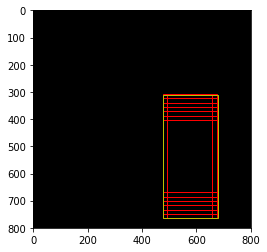

In [10]:
height = anchors[:,1,0] - anchors[:,0,0]
width = anchors[:,1,1] - anchors[:,0,1]
x_ctr = anchors[:,0,0] + 0.5 * heigth
y_ctr = anchors[:,0,1] + 0.5 * width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

idx = 12
fig, ax = plt.subplots(1)
ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, [anchors[i] for i in np.where(labels[idx] == 1)[0]])
draw_boxes(ax, resized_boxes[idx], 'y')

In [11]:
cnn = torchvision.models.vgg16().features[:29]

class RPN(nn.Module):
    def __init__(self, k):
        super(RPN, self).__init__()
        self.k = k
        self.inter = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU()
        )
        self.cls = nn.Conv2d(512, 18, 1, 1)
        self.reg = nn.Conv2d(512, 36, 1, 1)
        
    def forward(self, x):
        x = self.inter(x)
        return self.cls(x), self.reg(x)

class FasterRCNN(nn.Module):
    def __init__(self, cnn, k):
        super(FasterRCNN, self).__init__()
        self.k = k
        self.cnn = cnn
        self.rpn = RPN(self.k)
        cnn.eval()
    
    def forward(self, x):
        feature_map = self.cnn(x)
        cls, reg = self.rpn(feature_map)
        
        return cls, reg

device = "cuda:0" if torch.cuda.is_available() else "cpu"
net = FasterRCNN(cnn, 9).to(device)
LR = 0.001
EPOCH = 10
opt = optim.Adam(net.parameters(), lr = LR)
nll = nn.CrossEntropyLoss()
mse = nn.MSELoss(reduction=None)
gamma = 0.5

In [12]:
image = []
for i, (im, lb) in enumerate(dataloader):
    if lb != 1:
        continue
    image.append(im)

In [20]:
for epoch in range(EPOCH):
    for idx in range(len(image)):
        pos = np.where(labels[idx] == 1)[0]
        neg = random.sample(list(np.where(labels[idx] == 0)[0]), 128-len(pos))

        y = np.zeros(128)
        y[:len(pos)] = 1
        y = torch.LongTensor(y).to(device)

        y_box = torch.FloatTensor(np.concatenate([norm_locs[idx][pos], norm_locs[idx][neg]])).to(device)

        opt.zero_grad()
        cls, reg = net(image[idx].to(device))

        pred = cls.permute(0,2,3,1).reshape(-1,2).contiguous()
        pred_box = reg.permute(0,2,3,1).reshape(-1,4).contiguous()

        pred_selected = torch.cat([pred[pos], pred[neg]], 0)
        pred_box_selected = torch.cat([pred_box[pos], pred_box[neg]], 0)

        nll_loss = nll(pred_selected, y)
        mse_loss = (y.type(torch.FloatTensor).to(device)*(((pred_box_selected - y_box)**2).sum(1)**1/2)).sum()

        loss = nll_loss + gamma * mse_loss
        loss.backward()
        print("[%2d -%3d]"%(epoch, idx), nll_loss.item(), mse_loss.item(), loss.item())
        opt.step()

[ 0 -  0] 0.6982935070991516 33.870140075683594 17.633363723754883
[ 0 -  1] 6.057712078094482 11118.8671875 5565.4912109375
[ 0 -  2] 0.6601045727729797 0.3245839476585388 0.8223965167999268
[ 0 -  3] 0.6621803641319275 8.018861770629883 4.671611309051514
[ 0 -  4] 0.4110516905784607 11.689777374267578 6.2559404373168945
[ 0 -  5] 0.5542532801628113 2.9884376525878906 2.0484721660614014
[ 0 -  6] 0.6174526214599609 9.33838939666748 5.286647319793701
[ 0 -  7] 0.6296467781066895 15.705162048339844 8.482227325439453
[ 0 -  8] 0.6673711538314819 1.841270089149475 1.5880062580108643
[ 0 -  9] 0.6469171643257141 0.20494261384010315 0.7493884563446045
[ 0 - 10] 0.5877405405044556 0.14895041286945343 0.6622157692909241
[ 0 - 11] 0.38860780000686646 4.241241931915283 2.5092287063598633
[ 0 - 12] 0.5650501847267151 27.08888053894043 14.109490394592285
[ 0 - 13] 0.5969996452331543 0.14490817487239838 0.6694537401199341
[ 0 - 14] 0.5676000714302063 3.880129814147949 2.507664918899536
[ 0 - 15] 0

[ 0 -120] 0.05361250787973404 0.20804312825202942 0.15763407945632935
[ 0 -121] 0.05917079374194145 0.10602112859487534 0.11218135803937912
[ 0 -122] 0.07452446222305298 0.7218877077102661 0.43546831607818604
[ 0 -123] 0.06262379884719849 0.06077791005373001 0.0930127501487732
[ 0 -124] 0.07693679630756378 0.17910361289978027 0.16648860275745392
[ 0 -125] 0.10448360443115234 0.8787750601768494 0.5438711643218994
[ 0 -126] 0.04924900084733963 0.0474986769258976 0.07299833744764328
[ 0 -127] 0.03177643567323685 0.009991367347538471 0.036772120743989944
[ 0 -128] 0.0458236038684845 0.029083726927638054 0.0603654682636261
[ 0 -129] 0.05991704389452934 0.4413416385650635 0.2805878520011902
[ 0 -130] 0.032783009111881256 0.014492226764559746 0.040029123425483704
[ 0 -131] 0.07584641128778458 0.1445404589176178 0.14811664819717407
[ 0 -132] 0.05459121614694595 0.09534091502428055 0.10226167738437653
[ 0 -133] 0.07778945565223694 0.18789169192314148 0.17173530161380768
[ 0 -134] 0.276510953903

[ 1 - 68] 0.03908241540193558 0.1700585037469864 0.12411166727542877
[ 1 - 69] 0.05693599581718445 0.04950280487537384 0.08168739825487137
[ 1 - 70] 0.08092761784791946 0.7562953233718872 0.45907527208328247
[ 1 - 71] 0.09700069576501846 0.07152450829744339 0.13276295363903046
[ 1 - 72] 0.0432051345705986 0.06908278167247772 0.07774652540683746
[ 1 - 73] 0.048753395676612854 0.09036161750555038 0.09393420815467834
[ 1 - 74] 0.10993002355098724 1.6345181465148926 0.9271891117095947
[ 1 - 75] 0.09515594691038132 0.9761863350868225 0.5832490921020508
[ 1 - 76] 0.046422574669122696 0.24442051351070404 0.16863283514976501
[ 1 - 77] 0.10237883776426315 0.6182612180709839 0.4115094542503357
[ 1 - 78] 0.12902110815048218 0.49483901262283325 0.3764406144618988
[ 1 - 79] 0.07414765655994415 0.42411836981773376 0.28620684146881104
[ 1 - 80] 0.06620127707719803 0.15560930967330933 0.1440059244632721
[ 1 - 81] 0.05163021385669708 0.3705584704875946 0.23690944910049438
[ 1 - 82] 0.0772516056895256 0

[ 2 - 16] 0.03203008696436882 0.9584002494812012 0.5112302303314209
[ 2 - 17] 0.04374546557664871 0.5448110103607178 0.316150963306427
[ 2 - 18] 0.05469189211726189 0.11623956263065338 0.11281166970729828
[ 2 - 19] 0.025968041270971298 0.12616613507270813 0.08905111253261566
[ 2 - 20] 0.08635163307189941 0.6774997115135193 0.42510148882865906
[ 2 - 21] 0.14764763414859772 0.46863624453544617 0.3819657564163208
[ 2 - 22] 0.06466701626777649 0.1082218736410141 0.11877795308828354
[ 2 - 23] 0.04986429587006569 0.1570480316877365 0.12838831543922424
[ 2 - 24] 0.16222819685935974 2.5224547386169434 1.4234555959701538
[ 2 - 25] 0.05260023474693298 0.17558109760284424 0.1403907835483551
[ 2 - 26] 0.026834188029170036 1.0763884782791138 0.5650284290313721
[ 2 - 27] 0.03515152633190155 0.9348701238632202 0.5025866031646729
[ 2 - 28] 0.0715511217713356 0.08553241193294525 0.11431732773780823
[ 2 - 29] 0.0701129361987114 0.09394906461238861 0.1170874685049057
[ 2 - 30] 0.06729042530059814 0.08851

[ 2 -134] 0.22431832551956177 0.7632116079330444 0.605924129486084
[ 2 -135] 0.04840506613254547 0.2981765568256378 0.19749334454536438
[ 2 -136] 0.12501412630081177 0.7048660516738892 0.47744715213775635
[ 2 -137] 0.03688284009695053 0.016481012105941772 0.04512334614992142
[ 2 -138] 0.12873704731464386 0.07852433621883392 0.16799920797348022
[ 2 -139] 0.036237817257642746 0.19176824390888214 0.13212193548679352
[ 2 -140] 0.1439957469701767 0.24379248917102814 0.26589199900627136
[ 2 -141] 0.07131972908973694 0.3024832010269165 0.2225613296031952
[ 2 -142] 0.04672931879758835 0.15995115041732788 0.12670490145683289
[ 2 -143] 0.02828608825802803 0.34510165452957153 0.2008369117975235
[ 2 -144] 0.15341679751873016 0.5173426270484924 0.4120880961418152
[ 2 -145] 0.02443799562752247 0.2539588510990143 0.15141741931438446
[ 2 -146] 0.05957411229610443 0.028486328199505806 0.07381727546453476
[ 2 -147] 0.07252056896686554 0.5573028922080994 0.3511720299720764
[ 2 -148] 0.07922884821891785 0

[ 3 - 82] 0.14219793677330017 0.6417085528373718 0.4630522131919861
[ 3 - 83] 0.08321976661682129 0.5513696074485779 0.35890457034111023
[ 3 - 84] 0.05617004632949829 0.19020113348960876 0.15127061307430267
[ 3 - 85] 0.06489147245883942 0.005324011668562889 0.06755347549915314
[ 3 - 86] 0.08057007193565369 0.39661046862602234 0.27887529134750366
[ 3 - 87] 0.06945599615573883 0.20133525133132935 0.1701236218214035
[ 3 - 88] 0.06490403413772583 0.17338013648986816 0.1515941023826599
[ 3 - 89] 0.09378443658351898 0.20589101314544678 0.19672994315624237
[ 3 - 90] 0.0427369698882103 0.2545544505119324 0.17001420259475708
[ 3 - 91] 0.061698101460933685 0.06859180331230164 0.0959940031170845
[ 3 - 92] 0.10031464695930481 0.25197041034698486 0.22629985213279724
[ 3 - 93] 0.07231541723012924 0.16272833943367004 0.15367957949638367
[ 3 - 94] 0.06274721771478653 0.14036834239959717 0.13293138146400452
[ 3 - 95] 0.12641221284866333 0.8052172660827637 0.5290208458900452
[ 3 - 96] 0.0571685917675495

[ 4 - 29] 0.10186456143856049 0.09224721789360046 0.14798817038536072
[ 4 - 30] 0.059489648789167404 0.06495749205350876 0.09196839481592178
[ 4 - 31] 0.04563547298312187 0.0436871275305748 0.06747903674840927
[ 4 - 32] 0.08281589299440384 0.19917458295822144 0.18240317702293396
[ 4 - 33] 0.060667410492897034 0.4513928294181824 0.2863638401031494
[ 4 - 34] 0.046857260167598724 0.335028737783432 0.21437162160873413
[ 4 - 35] 0.17554441094398499 1.1354646682739258 0.7432767152786255
[ 4 - 36] 0.0754830613732338 0.2533497214317322 0.2021579146385193
[ 4 - 37] 0.03477224335074425 0.10638825595378876 0.08796636760234833
[ 4 - 38] 0.1743006408214569 0.3838566243648529 0.36622893810272217
[ 4 - 39] 0.07592740654945374 0.14107705652713776 0.14646592736244202
[ 4 - 40] 0.12969884276390076 0.45305347442626953 0.3562255799770355
[ 4 - 41] 0.05205998942255974 0.10829953104257584 0.10620975494384766
[ 4 - 42] 0.10316339880228043 0.08958244323730469 0.14795461297035217
[ 4 - 43] 0.11811075359582901 

[ 4 -147] 0.0780247300863266 0.34172600507736206 0.24888773262500763
[ 4 -148] 0.0805678591132164 0.28293561935424805 0.22203567624092102
[ 4 -149] 0.07750904560089111 0.21348583698272705 0.18425196409225464
[ 4 -150] 0.0364253893494606 0.20920893549919128 0.14102986454963684
[ 4 -151] 0.014007926918566227 0.056976452469825745 0.042496152222156525
[ 4 -152] 0.05925578624010086 0.18507128953933716 0.15179142355918884
[ 4 -153] 0.046497661620378494 0.17411983013153076 0.13355757296085358
[ 4 -154] 0.08734369277954102 0.0382179394364357 0.10645265877246857
[ 4 -155] 0.044638827443122864 0.2633298337459564 0.17630374431610107
[ 4 -156] 0.05094346031546593 0.2229193150997162 0.16240312159061432
[ 4 -157] 0.06688188016414642 1.2105860710144043 0.6721749305725098
[ 4 -158] 0.011628968641161919 0.07276319712400436 0.04801056534051895
[ 4 -159] 0.28307485580444336 1.8826022148132324 1.2243759632110596
[ 4 -160] 0.039782024919986725 0.12740105390548706 0.10348255187273026
[ 4 -161] 0.03112588450

[ 5 - 95] 0.12379749119281769 0.756675660610199 0.5021353363990784
[ 5 - 96] 0.04778453707695007 0.025914117693901062 0.060741595923900604
[ 5 - 97] 0.050700172781944275 0.12254180759191513 0.11197108030319214
[ 5 - 98] 0.17271310091018677 1.9143145084381104 1.1298704147338867
[ 5 - 99] 0.0467708446085453 0.18909664452075958 0.1413191705942154
[ 5 -100] 0.04656565189361572 0.2409927248954773 0.16706201434135437
[ 5 -101] 0.028319265693426132 0.054373063147068024 0.055505797266960144
[ 5 -102] 0.06864966452121735 0.2057749181985855 0.1715371310710907
[ 5 -103] 0.05772526562213898 0.3534122407436371 0.23443138599395752
[ 5 -104] 0.027550721541047096 0.021091796457767487 0.03809662163257599
[ 5 -105] 0.047155626118183136 0.03912356495857239 0.06671740859746933
[ 5 -106] 0.21643997728824615 2.579115867614746 1.505997896194458
[ 5 -107] 0.050794269889593124 0.13444314897060394 0.1180158406496048
[ 5 -108] 0.055495232343673706 0.18968500196933746 0.15033772587776184
[ 5 -109] 0.0771267190575

[ 6 - 42] 0.07802022248506546 0.043327197432518005 0.09968382120132446
[ 6 - 43] 0.15742509067058563 0.30560803413391113 0.3102291226387024
[ 6 - 44] 0.24265587329864502 0.1406429558992386 0.3129773437976837
[ 6 - 45] 0.11922374367713928 0.43413981795310974 0.33629363775253296
[ 6 - 46] 0.35146787762641907 0.7521448731422424 0.7275403141975403
[ 6 - 47] 0.19309741258621216 0.3412754535675049 0.3637351393699646
[ 6 - 48] 0.2507851719856262 0.45231643319129944 0.47694337368011475
[ 6 - 49] 0.09376825392246246 0.12278032302856445 0.1551584154367447
[ 6 - 50] 0.23605191707611084 0.11032881587743759 0.29121631383895874
[ 6 - 51] 0.13640615344047546 0.17021775245666504 0.22151502966880798
[ 6 - 52] 0.36089709401130676 0.37685316801071167 0.5493236780166626
[ 6 - 53] 0.06332789361476898 0.25927823781967163 0.1929670125246048
[ 6 - 54] 0.02676953561604023 0.11010187864303589 0.08182047307491302
[ 6 - 55] 0.29464399814605713 0.5403499603271484 0.5648189783096313
[ 6 - 56] 0.13276025652885437 0.

[ 6 -160] 0.03303975984454155 0.12655654549598694 0.09631803631782532
[ 6 -161] 0.03403705358505249 0.160951167345047 0.11451263725757599
[ 6 -162] 0.04815789684653282 0.29044097661972046 0.19337838888168335
[ 6 -163] 0.026140939444303513 0.16150230169296265 0.10689209401607513
[ 6 -164] 0.045223359018564224 0.15013271570205688 0.12028971314430237
[ 6 -165] 0.02983367070555687 0.12287545949220657 0.09127140045166016
[ 6 -166] 0.08483651280403137 0.6805747151374817 0.4251238703727722
[ 6 -167] 0.025354333221912384 0.04252476245164871 0.04661671444773674
[ 6 -168] 0.05716320127248764 0.0945577323436737 0.1044420674443245
[ 6 -169] 0.0487937368452549 0.47688567638397217 0.2872365713119507
[ 7 -  0] 0.3450028896331787 2.457272529602051 1.573639154434204
[ 7 -  1] 0.038759496062994 0.05222342163324356 0.06487120687961578
[ 7 -  2] 0.07971101999282837 0.14427760243415833 0.15184982120990753
[ 7 -  3] 0.0857224315404892 0.17207711935043335 0.17176099121570587
[ 7 -  4] 0.08231014013290405 0.4

[ 7 -108] 0.06519845873117447 0.1768971085548401 0.15364700555801392
[ 7 -109] 0.05716240406036377 0.05569997429847717 0.08501239120960236
[ 7 -110] 0.0289837084710598 0.0618370845913887 0.05990225076675415
[ 7 -111] 0.044859662652015686 0.016352225095033646 0.05303577333688736
[ 7 -112] 0.05388136953115463 0.033586177974939346 0.07067445665597916
[ 7 -113] 0.061108753085136414 0.03567935526371002 0.07894843071699142
[ 7 -114] 0.04407785087823868 0.013181723654270172 0.050668712705373764
[ 7 -115] 0.056776177138090134 0.20791342854499817 0.16073289513587952
[ 7 -116] 0.1369340717792511 1.084610104560852 0.6792391538619995
[ 7 -117] 0.10000944882631302 0.4755018651485443 0.33776038885116577
[ 7 -118] 0.14908131957054138 0.8819294571876526 0.5900460481643677
[ 7 -119] 0.08518914878368378 0.24206939339637756 0.20622384548187256
[ 7 -120] 0.038875170052051544 0.24123898148536682 0.15949466824531555
[ 7 -121] 0.043473608791828156 0.09396052360534668 0.0904538705945015
[ 7 -122] 0.0795452669

[ 8 - 55] 0.3577147424221039 0.5335544943809509 0.6244919896125793
[ 8 - 56] 0.1684805452823639 0.14643895626068115 0.24170002341270447
[ 8 - 57] 0.3073517978191376 3.4154160022735596 2.01505970954895
[ 8 - 58] 0.04149927198886871 0.4389908015727997 0.26099467277526855
[ 8 - 59] 0.07790856063365936 0.16683059930801392 0.16132386028766632
[ 8 - 60] 0.07027506083250046 0.3286776840686798 0.23461389541625977
[ 8 - 61] 0.03856820985674858 0.468537837266922 0.2728371322154999
[ 8 - 62] 0.14848025143146515 6.7640814781188965 3.5305209159851074
[ 8 - 63] 0.0730113610625267 0.2497674822807312 0.1978951096534729
[ 8 - 64] 0.07865443825721741 0.563457190990448 0.3603830337524414
[ 8 - 65] 0.0617721825838089 0.20758476853370667 0.16556456685066223
[ 8 - 66] 0.07105515152215958 0.12471838295459747 0.1334143429994583
[ 8 - 67] 0.05317709222435951 0.09461134672164917 0.1004827618598938
[ 8 - 68] 0.0630495548248291 0.12608958780765533 0.12609434127807617
[ 8 - 69] 0.07387268543243408 0.13243715465068

[ 9 -  3] 0.10888773947954178 0.26770880818367004 0.2427421510219574
[ 9 -  4] 0.059549927711486816 0.4981732964515686 0.3086365759372711
[ 9 -  5] 0.055023036897182465 0.1026664599776268 0.10635626316070557
[ 9 -  6] 0.081412672996521 0.2293495088815689 0.19608741998672485
[ 9 -  7] 0.18982437252998352 1.1783146858215332 0.7789816856384277
[ 9 -  8] 0.029881073161959648 0.20409193634986877 0.13192704319953918
[ 9 -  9] 0.018777333199977875 0.10091520100831985 0.0692349374294281
[ 9 - 10] 0.023011978715658188 0.06049733608961105 0.053260646760463715
[ 9 - 11] 0.024271588772535324 0.12241631746292114 0.0854797512292862
[ 9 - 12] 0.21890994906425476 0.2576656937599182 0.34774279594421387
[ 9 - 13] 0.04062069207429886 0.012998809106647968 0.047120098024606705
[ 9 - 14] 0.1007286012172699 0.4244126081466675 0.31293490529060364
[ 9 - 15] 0.05210166424512863 0.20970648527145386 0.15695491433143616
[ 9 - 16] 0.03575041517615318 0.497383177280426 0.2844420075416565
[ 9 - 17] 0.0654014870524406

[ 9 -121] 0.042067915201187134 0.08706319332122803 0.08559951186180115
[ 9 -122] 0.06517654657363892 0.5098482966423035 0.32010069489479065
[ 9 -123] 0.04998956620693207 0.0717635378241539 0.08587133884429932
[ 9 -124] 0.058690547943115234 0.18572300672531128 0.15155205130577087
[ 9 -125] 0.10298735648393631 0.4416714012622833 0.32382306456565857
[ 9 -126] 0.042946964502334595 0.08169279992580414 0.08379336446523666
[ 9 -127] 0.06055549904704094 0.03587070479989052 0.07849085330963135
[ 9 -128] 0.0445975661277771 0.07100488245487213 0.08010000735521317
[ 9 -129] 0.07356272637844086 0.4136251211166382 0.28037530183792114
[ 9 -130] 0.040688686072826385 0.03553937375545502 0.058458372950553894
[ 9 -131] 0.08513946086168289 0.16045492887496948 0.16536691784858704
[ 9 -132] 0.04356108978390694 0.12861140072345734 0.1078667938709259
[ 9 -133] 0.07519645988941193 0.20011965930461884 0.17525628209114075
[ 9 -134] 0.18412898480892181 0.4675781726837158 0.4179180860519409
[ 9 -135] 0.04737734422

In [21]:
net.eval()
cls, reg = net(image[0].to(device))
net.train()

FasterRCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [23]:
pred_anchors = reg.permute(0,2,3,1).contiguous().view(1,-1,4)

pred_cls = cls.permute(0,2,3,1).contiguous()
objective_score = pred_cls.view(1,50,50,9,2).contiguous()[:,:,:,:,1].contiguous().view(1, -1)
pred_cls_score = pred_cls.view(1,-1,2)

pred_anchors_np = pred_anchors[0].cpu().data.numpy()
objective_score_np = objective_score[0].cpu().data.numpy()

anchor_height = anchors[:,1,0] - anchors[:,0,0]
anchor_width = anchors[:,1,1] - anchors[:,0,1]
anchor_y_ctr = anchors[:,0,0] + anchor_height*0.5
anchor_x_ctr = anchors[:,0,1] + anchor_width*0.5

In [24]:
min_shape = 16
im_size = 800
train_pre_n = 12000
train_post_n = 2000
test_pre_n = 6000
test_post_n = 300

dy = pred_anchors_np[:,0]
dx = pred_anchors_np[:,1]
dh = pred_anchors_np[:,2]
dw = pred_anchors_np[:,3]

ctr_y = dy * anchor_height + anchor_y_ctr
ctr_x = dx * anchor_width + anchor_x_ctr
h = np.exp(dh) * anchor_height
w = np.exp(dw) * anchor_width

roi = np.zeros(pred_anchors_np.shape, dtype=np.float32)
roi[:,0] = np.clip(ctr_y - 0.5*h, 0, im_size)
roi[:,1] = np.clip(ctr_x - 0.5*w, 0, im_size)
roi[:,2] = np.clip(ctr_y + 0.5*h, 0, im_size)
roi[:,3] = np.clip(ctr_x + 0.5*w, 0, im_size)

In [25]:
min_satisfied = np.where((roi[:,2] - roi[:,0] >= min_shape) * (roi[:,3] - roi[:,1] >= min_shape))
roi = roi[min_satisfied]
score = objective_score_np[min_satisfied]

In [26]:
order = score.argsort()[::-1][:train_pre_n]
roi = roi[order]
scores = score[order]

thresh = 0.7

y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
area = (x2 - x1 + 1) * (y2 - y1 + 1)
order = scores.argsort()[::-1]
keep = []

In [27]:
while order.size > 0:
    i = order[0]
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (area[i] + area[order[1:]] - inter)
    inds = np.where(ovr <= thresh)[0]
    order = order[inds + 1]
    keep.append(i)
print(len(keep))
keep = keep[:train_post_n] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals

1365


In [121]:
score[keep].argsort()[::-1][:10]

array([ 203,  951,   36,  943,  674, 1156,  251, 1176,  688, 1172],
      dtype=int64)

In [34]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [35]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(resized_boxes[0]):
        (yb1, xb1), (yb2, xb2) = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(1365, 2)


In [36]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[1 1 0 ... 0 1 0]
[0.21666053 0.09005514 0.         ... 0.20682126 0.19483139 0.20682126]


In [37]:
gt_roi_label = gt_assignment

In [38]:
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(n_sample*pos_ratio, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

11
[1146  152  130 1218  219 1279  139  135 1327  771  138]


In [40]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
if neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

117
[ 472  478  781   13  835  553  313  210 1329  400  274 1193 1069   25
  168   27  828 1083  306 1171 1043 1247   52 1291  391  944  691  348
  314 1060  913  509  361  131  993 1261  315 1307  366  534  403 1328
  310  268  191   30 1074  631  292  676  888 1109  540  651 1220  991
  720 1320 1227  523  215 1332 1019  963  696  532  513  232  610  474
  413   12  955 1259 1104  956 1364   54   48  582   96  347 1360  626
 1311  583  459  970  933  937  667  896 1173  270  864  495 1336  353
  406 1127 1347  660 1106  566  388 1056  798 1251  524 1014 1099    7
  204  235 1021 1192  209]


In [41]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


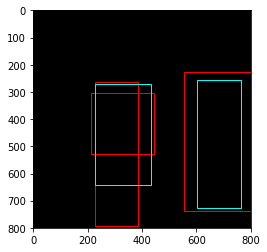

In [136]:
fig, ax = plt.subplots(1)
ax.imshow(np.zeros((800,800,3),dtype=np.uint8))
draw_boxes(ax, random.sample(list(roi[pos_index].reshape(-1,2,2)),3))
draw_boxes(ax, resized_boxes[0], '#00ffff')

In [108]:
cond = np.where((roi[:,2]-roi[:,0]) / (roi[:,3] - roi[:,1]) < 1/3)

In [96]:
roi[cond].reshape(-1,2,2)

array([[[102.87285 , 657.91785 ],
        [776.05756 , 800.      ]],

       [[  0.      , 657.91785 ],
        [584.05756 , 800.      ]],

       [[636.9525  , 749.64026 ],
        [800.      , 800.      ]],

       [[ 60.95252 , 749.64026 ],
        [237.59781 , 800.      ]],

       [[108.95252 , 749.6402  ],
        [285.5978  , 800.      ]],

       [[220.95251 , 749.6402  ],
        [397.5978  , 800.      ]],

       [[156.95251 , 749.6402  ],
        [333.5978  , 800.      ]],

       [[188.95251 , 749.6402  ],
        [365.5978  , 800.      ]],

       [[332.9525  , 749.6402  ],
        [509.5978  , 800.      ]],

       [[268.9525  , 749.6402  ],
        [445.5978  , 800.      ]],

       [[396.9525  , 749.64026 ],
        [573.59784 , 800.      ]],

       [[364.9525  , 749.64026 ],
        [541.59784 , 800.      ]],

       [[524.9525  , 749.6402  ],
        [701.59784 , 800.      ]],

       [[ 12.952523, 749.6402  ],
        [189.59781 , 800.      ]],

       [[300.9525  ,

In [63]:
bbox_for_sampled_roi = np.array(resized_boxes[0])[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
#Out
#(128, 4)
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width
base_height = bbox_for_sampled_roi[:, 1,0] - bbox_for_sampled_roi[:, 0,0]
base_width = bbox_for_sampled_roi[:, 1,1] - bbox_for_sampled_roi[:, 0,1]
base_ctr_y = bbox_for_sampled_roi[:, 0,0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 0,1] + 0.5 * base_width

(128, 2, 2)


In [64]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs)

[[ 9.12784601e-03 -2.45506181e-01 -1.37163680e-01  4.98150034e-01]
 [ 5.15472695e-02 -4.42135637e-02  2.51356683e-01 -3.57931248e-01]
 [ 1.52888638e-01  7.63895438e-02  2.51356683e-01 -3.57931248e-01]
 [ 7.78433151e-02 -3.25887890e-02 -1.37163680e-01  4.98150034e-01]
 [ 1.52888638e-01 -1.34665894e-01  2.51356683e-01 -3.57931248e-01]
 [-5.95876230e-02  3.22273532e-01 -1.37163680e-01  4.98150034e-01]
 [-1.51135260e-01  1.60879901e-02  2.51356587e-01 -3.57931248e-01]
 [-4.97939010e-02  1.36691040e-01  2.51356587e-01 -3.57931248e-01]
 [ 9.12784601e-03  1.80328603e-01 -1.37163680e-01  4.98150034e-01]
 [ 2.24800647e-02  1.48704075e-02 -3.91095170e-01 -8.19697604e-02]
 [-1.51135260e-01 -2.01311848e-01  2.51356587e-01 -2.74872180e-01]
 [ 1.07326652e+00  1.66390817e+00  1.25703243e+00  5.62341105e-01]
 [ 7.96224148e-01  5.27491929e-01  1.25703243e+00  5.17831283e-01]
 [ 1.57788452e+00  1.70326356e+00  2.43949639e-01  7.65337972e-01]
 [ 1.54893496e+00  5.79716778e-01  2.29919447e-01 -1.32876058e

 [ 1.26764357e+00  3.47746478e-01  2.51356587e-01 -3.57931248e-01]]


In [65]:
gt_roi_locs.shape

(128, 4)